In [ ]:
# Libraries

import os
import cv2
import numpy as np
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Flatten, Dense, Conv2DTranspose, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split, GroupShuffleSplit

import dotenv

2024-11-23 16:18:16.029431: E external/local_xla/xla/stream_executor/plugin_registry.cc:93] Invalid plugin kind specified: DNN


### Hyperparameters

In [ ]:
# Load environment variables
dotenv.load_dotenv()

EPOCHS = 50
BATCH_SIZE = 128  # Reduced batch size for multi-task learning
IMAGE_SIZE = 128
NUM_CLASSES = 2  # Binary classification: Tumor or No Tumor

### Import Dataset

In [ ]:
# Dataset paths
dataset_path = os.path.join(os.environ['SEGMENTATION_DATASET_PATH'], 'kaggle_3m')
data_csv_path = os.path.join(dataset_path, 'data.csv')

# Load patient data
patient_data = pd.read_csv(data_csv_path)

# Initialize lists to store images and masks for the dataset
images = []
masks = []
classification_labels = []
patient_ids = []

# Loop over each folder (patient case) in the dataset to load images and corresponding masks
case_folders = sorted(os.listdir(dataset_path))
for folder in case_folders:
    folder_path = os.path.join(dataset_path, folder)
    if not os.path.isdir(folder_path):
        continue  # Skip non-directory files

    # List image and mask files in the folder
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.tif') and '_mask' not in f])
    mask_files = sorted([f for f in os.listdir(folder_path) if f.endswith('_mask.tif')])

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(folder_path, img_file)
        mask_path = os.path.join(folder_path, mask_file)

        # Read the image (3-channel TIFF)
        img = tiff.imread(img_path)
        
        # Handle missing channels by repeating the FLAIR sequence if needed
        if img.shape[-1] < 3:
            img = np.repeat(img[..., :1], 3, axis=-1)  # Repeat FLAIR if missing sequences

        # Resize image if necessary (standardize image size)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))

        # Read the mask (1-channel TIFF)
        mask = tiff.imread(mask_path)
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
        mask = mask.astype(np.uint8)
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

        # Append image, mask, and classification label
        images.append(img)
        masks.append(mask)
        classification_labels.append(1 if np.max(mask) > 0 else 0)  # 1 if tumor present, else 0

In [ ]:
# Convert lists to numpy arrays after appending all images, masks, and labels
images = np.array(images)
masks = np.array(masks)
classification_labels = np.array(classification_labels)
patient_ids = np.array(patient_ids)

# Normalize the images (optional but helps with training)
images = images.astype('float32') / 255.0

# Normalize the masks
masks = masks.astype('float32') / 255.0

# One-hot encode classification labels
classification_labels = to_categorical(classification_labels, num_classes=NUM_CLASSES)

# Split the dataset into training, validation, and testing sets (70% training, 15% validation, 15% testing)
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)
train_idx, temp_idx = next(gss.split(images, classification_labels, groups=patient_ids))

X_train, X_temp = images[train_idx], images[temp_idx]
y_train, y_temp = masks[train_idx], masks[temp_idx]
y_class_train, y_class_temp = classification_labels[train_idx], classification_labels[temp_idx]
patient_ids_temp = patient_ids[temp_idx]

# Split the remaining data into validation and testing sets (50% each of the remaining 30%)
gss = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=42)
val_idx, test_idx = next(gss.split(X_temp, y_class_temp, groups=patient_ids_temp))

X_val, X_test = X_temp[val_idx], X_temp[test_idx]
y_val, y_test = y_temp[val_idx], y_temp[test_idx]
y_class_val, y_class_test = y_class_temp[val_idx], y_class_temp[test_idx]


In [ ]:
# Define the U-Net model for segmentation with an additional classification head
def unet_multi_task_model(input_size=(IMAGE_SIZE, IMAGE_SIZE, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Segmentation output
    segmentation_output = Conv2D(1, (1, 1), activation='sigmoid', name='segmentation_output')(c9)

    # Classification output from bottleneck
    classification_pooling = GlobalAveragePooling2D()(c5)
    classification_output = Dense(NUM_CLASSES, activation='softmax', name='classification_output')(classification_pooling)

    model = Model(inputs=[inputs], outputs=[segmentation_output, classification_output])
    return model

In [ ]:
# Create the U-Net multi-task model
model = unet_multi_task_model()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss={'segmentation_output': 'binary_crossentropy', 'classification_output': 'categorical_crossentropy'},
              metrics={'segmentation_output': 'accuracy', 'classification_output': 'accuracy'})

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# Train the model using the training data
history = model.fit(
    X_train, 
    {'segmentation_output': y_train, 'classification_output': y_class_train},
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(X_val, {'segmentation_output': y_val, 'classification_output': y_class_val})
)

Epoch 1/50


I0000 00:00:1732396726.051966     436 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


36/36 [==============================] - 57s 1s/step - loss: 0.9136 - segmentation_output_loss: 0.3479 - classification_output_loss: 0.5656 - segmentation_output_accuracy: 0.8720 - classification_output_accuracy: 0.7827 - val_loss: 3.8589 - val_segmentation_output_loss: 0.6003 - val_classification_output_loss: 3.2586 - val_segmentation_output_accuracy: 0.8863 - val_classification_output_accuracy: 0.2520
Epoch 2/50
36/36 [==============================] - 35s 981ms/step - loss: 0.2222 - segmentation_output_loss: 0.1091 - classification_output_loss: 0.1132 - segmentation_output_accuracy: 0.9511 - classification_output_accuracy: 0.9628 - val_loss: 3.4930 - val_segmentation_output_loss: 0.7552 - val_classification_output_loss: 2.7378 - val_segmentation_output_accuracy: 0.8863 - val_classification_output_accuracy: 0.2520
Epoch 3/50
36/36 [==============================] - 34s 951ms/step - loss: 0.0815 - segmentation_output_loss: 0.0435 - classification_output_loss: 0.0379 - segmentation_out

In [ ]:
# Save Model Output
model.save('segmentation_classification_model.h5')

# Save the model history to a file
with open('segmentation_classification_training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

/home/romit/.local/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


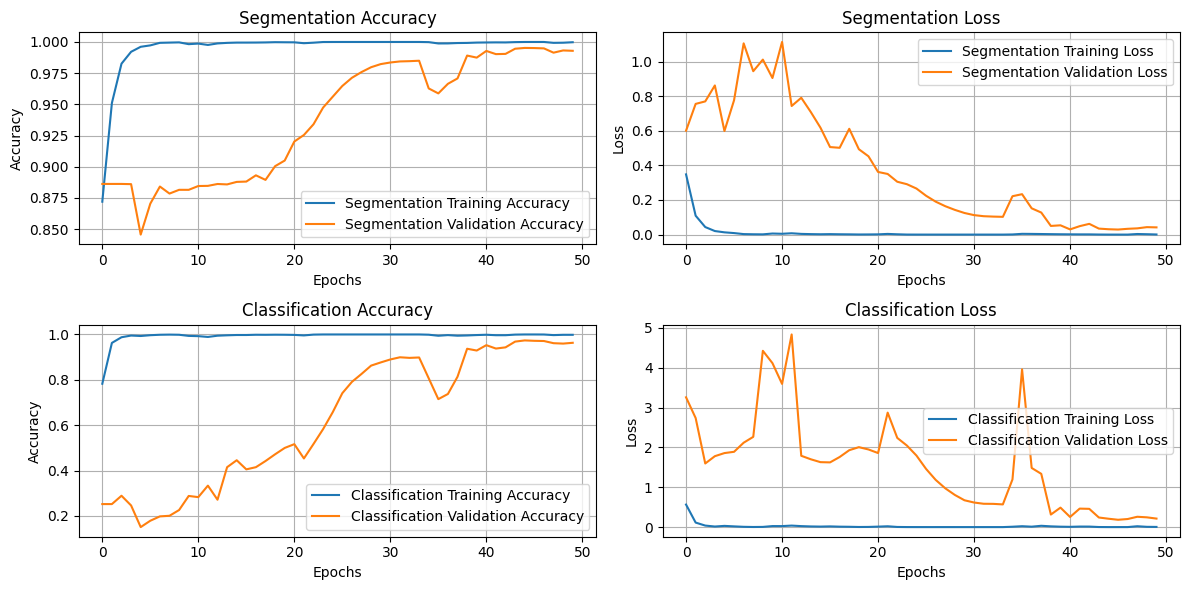

36/36 [==============================] - 8s 135ms/step - loss: 0.2552 - segmentation_output_loss: 0.0417 - classification_output_loss: 0.2135 - segmentation_output_accuracy: 0.9929 - classification_output_accuracy: 0.9633
Validation Loss: 0.2552027404308319
Segmentation Loss: 0.04169129580259323, Segmentation Accuracy: 0.992912232875824
Classification Loss: 0.2135114222764969, Classification Accuracy: 0.9632545709609985


In [ ]:
# Training Graph: Accuracy and Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['segmentation_output_accuracy'], label='Segmentation Training Accuracy')
plt.plot(history.history['classification_output_accuracy'], label='Classification Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['segmentation_output_loss'], label='Segmentation Training Loss')
plt.plot(history.history['classification_output_loss'], label='Classification Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

test_results = model.evaluate(X_test, {'segmentation_output': y_test, 'classification_output': y_class_test})

print(f"Testing Loss: {test_results[0]}")
print(f"Segmentation Loss: {test_results[1]}, Segmentation Accuracy: {test_results[3]}")
print(f"Classification Loss: {test_results[2]}, Classification Accuracy: {test_results[4]}")


In [ ]:
# Function to test the model on PNG or other images
def test_image(model, image_path):
    # Load and preprocess the input image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to match training input size
    img = img.astype('float32') / 255.0  # Normalize
    img = img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3)  # Add batch dimension
    
    # Predict the segmentation mask and class label
    segmentation_pred, classification_pred = model.predict(img)
    predicted_mask = (segmentation_pred > 0.5).astype(np.uint8)  # Threshold the output to get binary mask
    predicted_class = np.argmax(classification_pred, axis=1)
    predicted_label = 'Tumor' if predicted_class[0] == 1 else 'No Tumor'

    # Plot the input image, predicted mask, and classification label
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img[0, :, :, :], cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask[0, :, :, 0], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, f'Predicted Class: {predicted_label}', fontsize=12, ha='center')
    plt.axis('off')
    plt.title('Classification Result')

    plt.tight_layout()
    plt.show()

# Example usage for PNG or other images
test_image_path = 'test.png'
test_image(model, test_image_path)
